In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from lib.loads import parse_loads, convert_offline_to_online_input, select_load_from_last_day
from lib.model import build_model, FACEBOOK_2009_0, FACEBOOK_2009_1, FACEBOOK_2010, LANL_MUSTANG, ALIBABA, ENERGY_MODEL_WIERMAN, ENERGY_MODEL_ALTERNATIVE
from lib.utils import summarize_distribution, plot_cdf, plot

In [3]:
# import logging

# FORMAT = '%(levelname)s %(name)s %(asctime)-15s %(filename)s:%(lineno)d %(message)s'
# logging.basicConfig(format=FORMAT)
# logging.getLogger().setLevel(logging.DEBUG)

In [4]:
TIME_SLOT_LENGTH = 60 * 60
NORMALIZED_SWITCHING_COST = 4
REVENUE_LOSS = 0.1

In [5]:
TRACE = ALIBABA

# Model

In [6]:
model = build_model(
  TRACE,
  ENERGY_MODEL_WIERMAN,
  TIME_SLOT_LENGTH,
  NORMALIZED_SWITCHING_COST,
  REVENUE_LOSS,
)

# Inputs

In [7]:
offline_input = select_load_from_last_day(parse_loads(TRACE), TIME_SLOT_LENGTH)
perfect_knowledge_online_input = convert_offline_to_online_input(offline_input)


In [8]:
offline_input

[[77680, 12362, 105, 2319],
 [102062, 13705, 628, 6870],
 [71522, 10655, 164, 550],
 [24183, 3024, 33, 3440],
 [2, 0, 0, 0],
 [4, 0, 0, 0],
 [0, 0, 0, 0],
 [2, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 0],
 [1, 0, 0, 0],
 [3, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [0, 0, 0, 0],
 [1, 0, 0, 0],
 [0, 0, 0, 0],
 [1, 0, 0, 0]]

# Execute

## Offline

In [9]:
from lib.offline import evaluate_1d

opt, iopt, runtime_opt, runtime_iopt = evaluate_1d(model, offline_input)

INFO soco.bindings.data_center.offline 2021-08-02 19:40:47,528 offline.rs:60 1d Graph Search
INFO soco.streaming.offline 2021-08-02 19:40:47,533 offline.rs:45 Generated a problem instance: SimplifiedSmoothedConvexOptimization { d: 1, t_end: 24, bounds: [4000], switching_cost: [4.0] }
INFO soco.streaming.offline 2021-08-02 19:40:47,534 offline.rs:47 Simulating until time slot 24.
DEBUG soco.model.data_center.loads 2021-08-02 19:40:47,535 loads.rs:520 4;4


In [10]:
opt, iopt

(47035366.871634364, 47064852.08591507)

In [11]:
from lib.offline import evaluate_static

opts, iopts, runtime_opts, runtime_iopts = evaluate_static(model, offline_input)

In [12]:
opts, iopts

(296747933.68855405, 296747951.219958)

### Fractional vs Integral

In [13]:
opt_vs_iopt = iopt / opt
opts_vs_iopts = iopts / opts
opt_vs_iopt, opts_vs_iopts

(1.0006268732709405, 1.0000000590784366)

### Opt vs OptS

In [14]:
opt_vs_opts = opts / opt
iopt_vs_iopts = iopts / iopt
opt_vs_opts, iopt_vs_iopts

(6.309038356146297, 6.305086238840316)

### Runtimes

In [15]:
runtime_opt, runtime_iopt, runtime_opts, runtime_iopts

(79572, 1109, 4026, 154864)

### Approximation algorithm

In [16]:
gammas = np.logspace(
  0.2, 3, 8, base=2
)
gammas

array([1.14869835, 1.51571657, 2.        , 2.63901582, 3.48220225,
       4.59479342, 6.06286627, 8.        ])

In [17]:
from lib.offline import evaluate_approx_graph_search

x, y, approx_opt_runtimes = evaluate_approx_graph_search(model, offline_input, gammas)

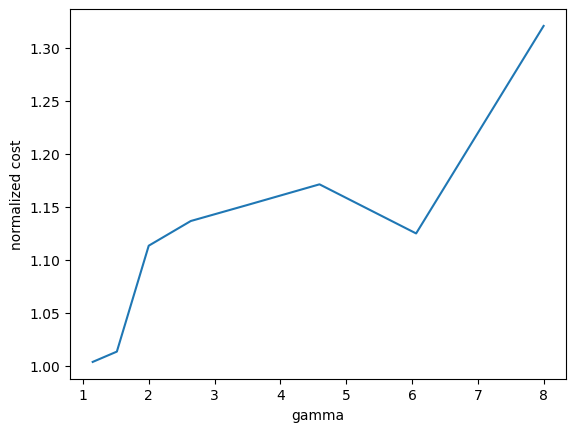

In [18]:
# plt.axhline(y=iopt, color='r', linestyle='-')
plot(x, np.array(y) / iopt, 'gamma', 'normalized cost', 'approx_graph_search')
plt.show()

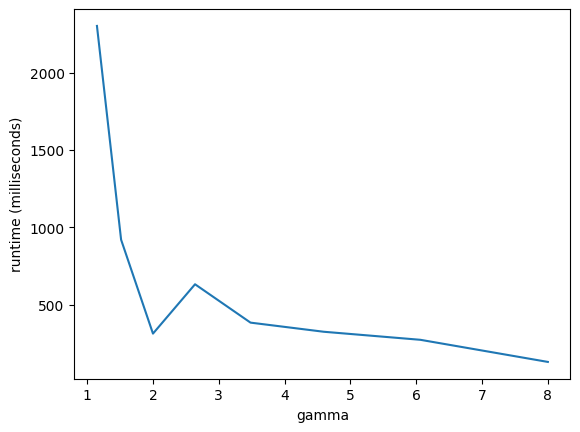

In [19]:
plot(x, approx_opt_runtimes, 'gamma', 'runtime (milliseconds)', 'approx_graph_search_runtime')
plt.show()

## Online

In [15]:
from lib.online import evaluate_probabilistic

initial_alg, alg, initial_ialg, ialg, energy_cost, revenue_loss, switching_cost, initial_runtime, runtimes = evaluate_probabilistic(model, [], perfect_knowledge_online_input)

  0%|          | 0/24 [00:00<?, ?it/s]Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
  4%|▍         | 1/24 [00:01<00:23,  1.02s/it]Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum iterations exceeded
Integration failed with message: integrate: maximum 

In [14]:
alg, ialg, energy_cost, revenue_loss, switching_cost

(47064853.720321834,
 47064853.720321834,
 38775600.0,
 8273357.720321834,
 15896.0)

## Evaluation

### Competitive Ratio

In [ ]:
cr = alg / opt
icr = ialg / iopt
cr, icr

(1.0006406356390443, 1.0)

### Competitive Difference

In [ ]:
cd = alg - opt
icd = ialg - iopt
cd, icd

(6133.159622054547, 0.0)

### Regret

In [ ]:
regret = alg - opts
iregret = ialg - iopts
regret, iregret

(-36423379.462355115, -36423474.47983452)

### Cost Change

Regret relative to overall cost.

In [ ]:
rel_regret = regret / opts
rel_iregret = iregret / iopts
rel_regret, rel_iregret

(-0.791759820845855, -0.7917602509566648)

Competitive difference relative to overall cost.

In [ ]:
rel_cd = cd / opt
rel_icd = icd / iopt
rel_cd, rel_icd

(0.0006406356390442987, 0.0)

### Fractional vs Integral

In [ ]:
alg_vs_ialg = ialg / alg
alg_vs_ialg

1.0

### Runtime

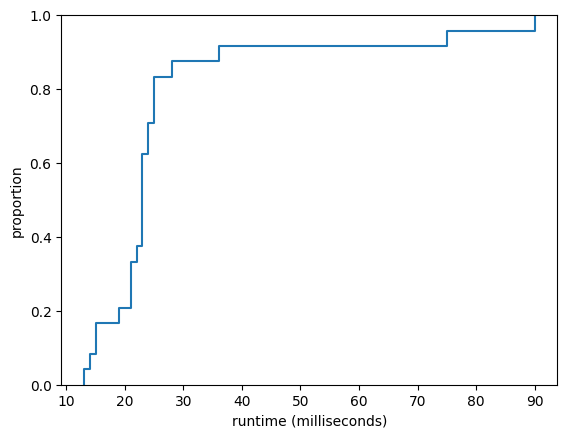

DistributionSummary(mean=27.125, median=23.0, modes=array([23]), std=17.476919303279207, mad=2.0, min_=13, p25=21.0, p75=25.0, max_=90)

In [ ]:
runtimes_np = np.array(runtimes)
plot_cdf(runtimes_np, 'runtime (milliseconds)', 'online_runtime')
plt.show()
summarize_distribution(runtimes_np)

### Model

Proportion of energy cost to delay cost

In [ ]:
ec_vs_rl = energy_cost / revenue_loss if revenue_loss > 0 else np.Inf
hc_vs_sc = (energy_cost + revenue_loss) / switching_cost
ec_vs_rl, hc_vs_sc

(4.928890525519765, 1841.2474518509073)